### Scanpy Integration
Trying to integrate [Scanpy](https://scanpy.readthedocs.io/en/stable/index.html) into scRNA-seq processing workflow.  
Testing out simple read-write, dimension reduction, and visualization with basic Scanpy tools.

In [1]:
import sys
sys.path.append('../')
from fcc_utils import *
sc.settings.set_figure_params(dpi=80)

In [97]:
# reload fcc module while working
del sys.modules['fcc_utils']
from fcc_utils import *

In [7]:
%%time
retina = sc.read('../inputs/GSM1626793_P14Retina_1.digital_expression_filtered_CH.tsv.gz')
retina.shape # cells x genes

Only considering the two last: ['.tsv', '.gz'].
Only considering the two last: ['.tsv', '.gz'].
CPU times: user 2.51 s, sys: 11.3 ms, total: 2.52 s
Wall time: 2.52 s


(1326, 20478)

In [8]:
%time recipe_fcc(retina, mito_names=':mt-') # preprocess adata object

CPU times: user 1.46 s, sys: 50.3 ms, total: 1.51 s
Wall time: 1.51 s


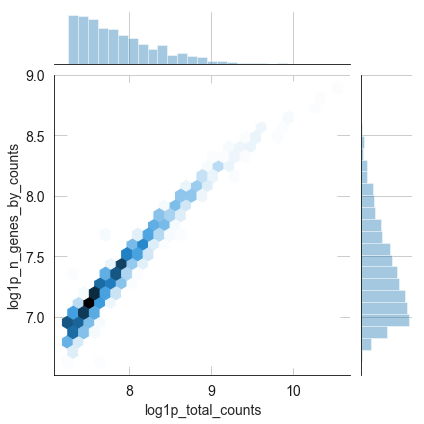

In [9]:
# generate some QC plots
sns.jointplot("log1p_total_counts", "log1p_n_genes_by_counts", data=retina.obs, kind="hex")

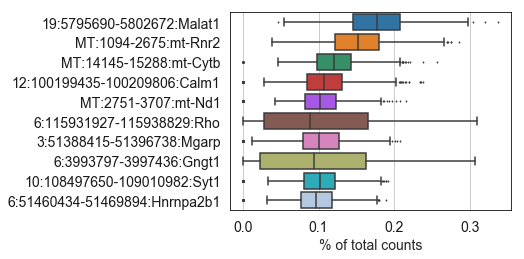

In [10]:
sc.pl.highest_expr_genes(retina, n_top=10)

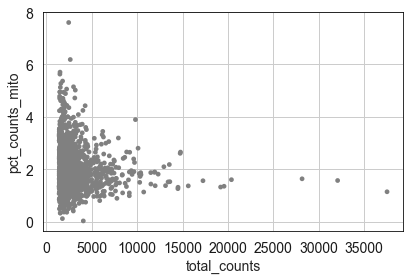

In [12]:
sc.pl.scatter(retina, x='total_counts', y='pct_counts_mito')

In [17]:
%%time
# run PCA on log1p normalized counts and gf-icf scores to compare outputs
sc.tl.pca(data=retina, n_comps=100)
retina.obsm['gf-icf_PCA'] = sc.tl.pca(data=retina.layers['gf-icf'], n_comps=100)

CPU times: user 10.3 s, sys: 1.58 s, total: 11.8 s
Wall time: 1.2 s


In [32]:
%%time
# create neighborhood graphs from both PCA results
# heads-up: you will get a numba deprecation warning the first time you run this
sc.pp.neighbors(retina, n_neighbors=30, use_rep='X_pca', n_pcs=100, knn=True, random_state=18, metric='euclidean', copy=False)
gficf_neighbors = sc.pp.neighbors(retina, n_neighbors=30, use_rep='gf-icf_PCA', knn=True, random_state=18, metric='euclidean', copy=True)
retina.uns['gf-icf_neighbors'] = gficf_neighbors.uns['neighbors'] # put gf-icf neighbor graph in .uns

CPU times: user 641 ms, sys: 106 ms, total: 747 ms
Wall time: 294 ms


In [34]:
%%time
# perform Louvain clustering on both graphs
sc.tl.louvain(retina, resolution=1.0, key_added='louvain', adjacency=retina.uns['neighbors']['connectivities'], random_state=18, copy=False)
sc.tl.louvain(retina, resolution=1.0, key_added='gf-icf_louvain', adjacency=retina.uns['gf-icf_neighbors']['connectivities'], random_state=18, copy=False)

CPU times: user 211 ms, sys: 2.85 ms, total: 214 ms
Wall time: 213 ms


In [115]:
%%time
# run t-SNE on both PCA results and plot using Louvain clusters
sc.tl.tsne(retina, use_rep='X_pca', n_pcs=100, perplexity=30, random_state=18, copy=False)
gficf_tsne = sc.tl.tsne(retina, use_rep='gf-icf_PCA', perplexity=30, random_state=18, copy=True)
retina.obsm['X_gf-icf_tsne'] = gficf_tsne.obsm['X_tsne'] # put gf-icf t-SNE results in .obsm

CPU times: user 22 µs, sys: 1 µs, total: 23 µs
Wall time: 25 µs


In [41]:
retina.obsm

AxisArrays with keys: X_pca, gf-icf_PCA, X_tsne, gf-icf_tsne

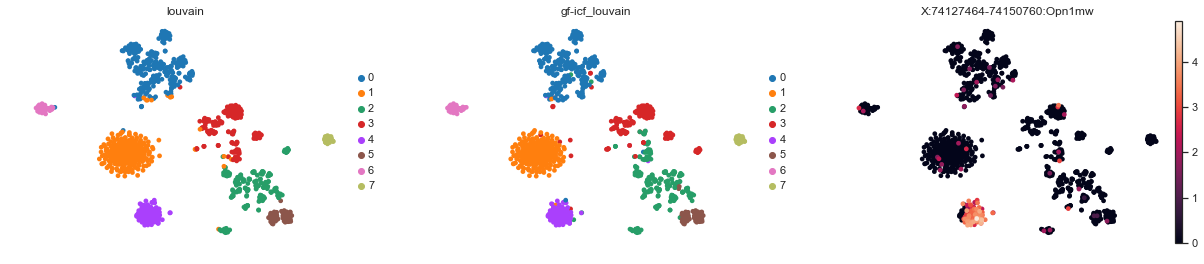

In [73]:
sc.pl.tsne(retina, color=['louvain','gf-icf_louvain',retina.var_names[retina.var_names.str.contains('Opn1mw')][0]], frameon=False, use_raw=False)

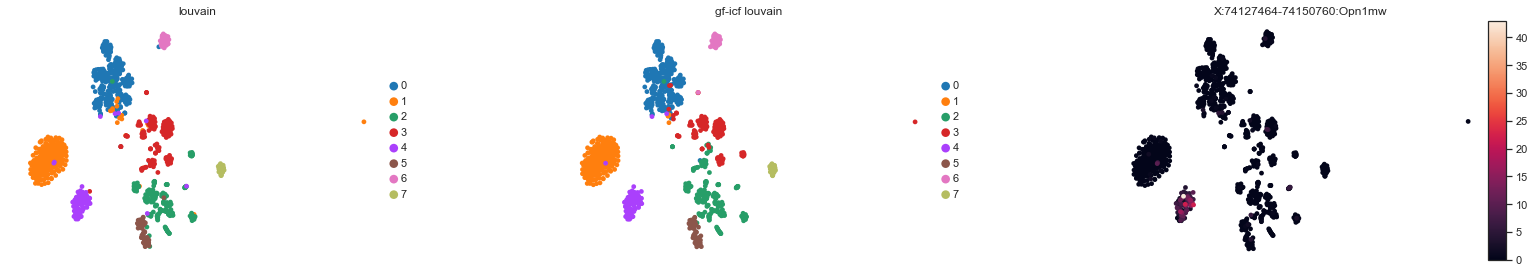

In [118]:
sc.pl.scatter(retina, basis='gf-icf_tsne', color=['louvain','gf-icf_louvain',retina.var_names[retina.var_names.str.contains('Opn1mw')][0]], frameon=False)

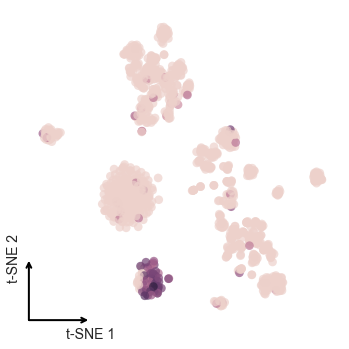

In [55]:
plot_DR(data=retina.obsm['X_tsne'], color=retina.obs_vector(retina.var_names[retina.var_names.str.contains('Opn1mw')][0]), dim_name='t-SNE')

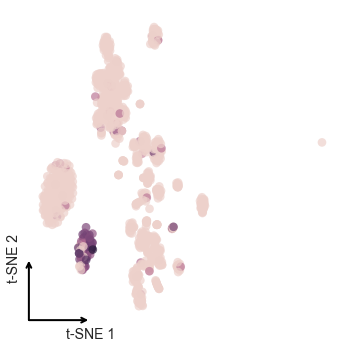

In [56]:
plot_DR(data=retina.obsm['gf-icf_tsne'], color=retina.obs_vector(retina.var_names[retina.var_names.str.contains('Opn1mw')][0]), dim_name='t-SNE')

In [105]:
retina.obs['louvain'].astype(str)

GGCCGCAGTCCG    7
CTTGTGCGGGAA    7
GCGCAACTGCTC    7
GATTGGGAGGCA    7
CCTCCTAGTTGG    7
               ..
ACAGGGGCTCCG    0
GTGCCACATCAC    2
GTCGAGTCTGGG    1
CACTTGAGAGCC    1
ATAGCTAAATTA    1
Name: louvain, Length: 1326, dtype: object

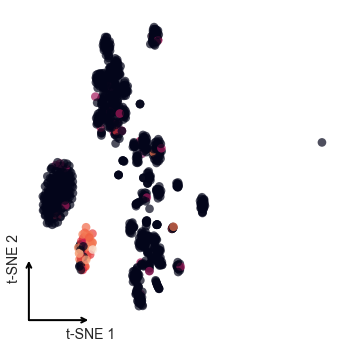

In [109]:
plot_DR(data=retina.obsm['gf-icf_tsne'], color=retina.obs_vector(retina.var_names[retina.var_names.str.contains('Opn1mw')][0]), dim_name='t-SNE')